<a href="https://colab.research.google.com/github/rennyatwork/10_cours-A61/blob/main/TP01/taxi_qlearning_v03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.8 MB/s eta 0:00:00


In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output


def create_q_table(env):
  """Creates a Q-table with all values initialized to 0.

  Args:
    env: The Gymnasium environment.

  Returns:
    A NumPy array representing the Q-table.
  """
  return np.zeros([env.observation_space.n, env.action_space.n])

def plot_reward_evolution(rewards
                          , pXLabel = 'Episode'
                          , pYLabel = 'Reward'
                          , pTitle='Reward Evolution during Training'):
  """Plots the evolution of rewards over episodes.

  Args:
    rewards: A list of rewards obtained during training.
  """
  plt.clf() #clear cell
  plt.plot(rewards)
  plt.xlabel(pXLabel)
  plt.ylabel(pYLabel)
  plt.title(pTitle)

  # Calculate tick positions for 10 evenly spaced labels
  num_ticks = 10
  x_min = 0  # Assume x-axis starts at 0
  x_max = len(rewards) - 1  # Assume x-axis ends at the last data point
  tick_positions = np.linspace(x_min, x_max, num_ticks, dtype=int)

   # Set x-axis ticks and labels
  plt.xticks(tick_positions, tick_positions)  # Set both positions and labels


  plt.show()

def get_policy(q_table, state, epsilon):
  """Selects an action using the epsilon-greedy policy.

  Args:
    q_table: The Q-table containing learned values.
    state: The current state of the environment.
    epsilon: The exploration rate.

  Returns:
    The action selected by the policy.
  """
  if np.random.uniform(0, 1) < epsilon:
    action = env.action_space.sample()  # Explore action space
  else:
    action = np.argmax(q_table[state])  # Exploit learned values
  return action

def train_q_learning(env
                     , q_table
                     , alpha=0.1
                     , gamma=0.9
                     , epsilon=1.0
                     , episodes=100000
                     , pPrint=False
                     ):
  """Trains the Q-learning agent.

  Args:
    env: The Gymnasium environment.
    q_table: The Q-table to update.
    alpha: The learning rate.
    gamma: The discount factor.
    epsilon: The exploration rate.
    episodes: The number of training episodes.

    Returns:
    A tuple containing the trained Q-table and the list of rewards per episode.
  """

  rewards = []
  all_rewards_per_episode = [] # List to store rewards per episode
  epsilon_decay = 0.9999  # Example decay rate


  for i in range(1, episodes + 1):
    state = env.reset()[0]
    epochs, penalties, reward = 0, 0, 0
    done = False


    while not done:

      action = get_policy(q_table, state, epsilon)

      # Decay epsilon over time:
      epsilon *= epsilon_decay
      epsilon = max(epsilon, 0.1) # set the min epsilon

      next_state, reward, done, truncated, info = env.step(action)

      old_value = q_table[state, action]
      next_max = np.max(q_table[next_state])

      new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
      q_table[state, action] = new_value

      if reward == -10:
        penalties += 1

      state = next_state
      epochs += 1

      rewards.append(reward)




    if pPrint:
      print("****************************************************")
      print(f"Episode: {i}")
      print(f"Timesteps taken: {epochs}")
      print(f"Penalties incurred: {penalties}")


    all_rewards_per_episode.append(np.mean(rewards)) # Calculating avg. reward per episode

    ten_pct_print = int(episodes/10)

    if i % (ten_pct_print) == 0:
      #print(f"Episode: {i}")
      avg_reward_last_100 = np.mean(all_rewards_per_episode[-ten_pct_print:]) # Calculating avg. reward for the last 100 episodes
      print(f"Episode: {i}, Average reward (last {ten_pct_print} episodes): {avg_reward_last_100}, current epsilon: {epsilon}")


    #if i % 1000 == 0:
     # plot_reward_evolution(rewards)

  print("Training finished.\n")
  return q_table, all_rewards_per_episode  # Return the Q-table and reward history

def evaluate_agent(env, q_table, episodes=100, pPrint=False):
  """Evaluates the trained agent.

  Args:
    env: The Gymnasium environment.
    q_table: The trained Q-table.
    episodes: The number of evaluation episodes.

  Returns:
    The average reward over the evaluation episodes.
  """

  if pPrint:
      print('Evaluating agent...')

  arr_avg_rewards = []
  arr_total_rewards = []
  arr_total_steps = []
  arr_penalties = []

  total_rewards = 0
  for ep in range(episodes):
    state = env.reset()[0]
    done = False
    episode_reward = 0

    steps_so_far = 0
    penalties = 0


    while not done and (steps_so_far < 400 or penalties <30):
      action = np.argmax(q_table[state])
      state, reward, done, truncated, info = env.step(action)
      steps_so_far +=1

      episode_reward += reward

      if reward == -10:
        penalties += 1

      reward_per_step = episode_reward / steps_so_far


      if (pPrint and (steps_so_far % 50) ==0):
        print(f'steps_so_far: {steps_so_far}')
        print(f'Reward/step in episode [{ep}]: {reward_per_step}')

    total_rewards += episode_reward

    if pPrint:
      print(f"Episode [{ep}] [reward]: {episode_reward} - [reward/step]: {reward_per_step} - [penalties]: {penalties} - [total_steps]: {steps_so_far}")
      #print(f"Episode [{ep}] reward/step: {reward_per_step}")
      #print(f"Episode [{ep}] penalties: {penalties}")

    arr_total_steps.append(steps_so_far)
    arr_penalties.append(penalties)
    arr_avg_rewards.append(reward_per_step)
    arr_total_rewards.append(episode_reward)

  print(f"Results after {episodes} episodes:")
  print(f'len(arr_avg_rewards): {len(arr_avg_rewards)} ')
  print(f'len(arr_total_rewards): {len(arr_total_rewards)} ')
  print(f'len(arr_total_steps): {len(arr_total_steps)} ')
  print(f'len(arr_penalties): {len(arr_penalties)} ')


  plot_reward_evolution(arr_avg_rewards
                        , pYLabel='Average Reward'
                        , pTitle='Average Reward evolution')
  plot_reward_evolution(arr_total_rewards
                        , pYLabel='Total Rewards'
                        , pTitle='Total Rewards evolution')
  plot_reward_evolution(arr_total_steps
                        , pYLabel='Total Steps'
                        , pTitle='Total Steps evolution')
  plot_reward_evolution(arr_penalties
                        , pYLabel='Penalties'
                        , pTitle='Penalties evolution')

  return total_rewards / episodes



In [7]:
# Main execution
env = gym.make("Taxi-v3")
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=10000)
q_table2, rewards2 = train_q_learning(env, create_q_table(env), episodes=20000)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


Episode: 1000, Average reward (last 1000 episodes): -1.5651459628729134, current epsilon: 0.1
Episode: 2000, Average reward (last 1000 episodes): -1.244827057107675, current epsilon: 0.1
Episode: 3000, Average reward (last 1000 episodes): -1.0723684030448868, current epsilon: 0.1
Episode: 4000, Average reward (last 1000 episodes): -0.9380189789712327, current epsilon: 0.1
Episode: 5000, Average reward (last 1000 episodes): -0.8304508907446881, current epsilon: 0.1
Episode: 6000, Average reward (last 1000 episodes): -0.7434370846853708, current epsilon: 0.1
Episode: 7000, Average reward (last 1000 episodes): -0.6703525130722726, current epsilon: 0.1
Episode: 8000, Average reward (last 1000 episodes): -0.6075070909932655, current epsilon: 0.1
Episode: 9000, Average reward (last 1000 episodes): -0.5538398416409563, current epsilon: 0.1
Episode: 10000, Average reward (last 1000 episodes): -0.5074193337540321, current epsilon: 0.1
Training finished.

Episode: 2000, Average reward (last 2000

Evaluating agent...
Episode [0] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [1] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [2] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [3] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [4] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [5] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [6] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [7] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [8] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [9] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [10] [reward]: 12 - [reward/step]: 1.3333333333333333 - [penalties]: 0 - [total_steps]: 9
Episode

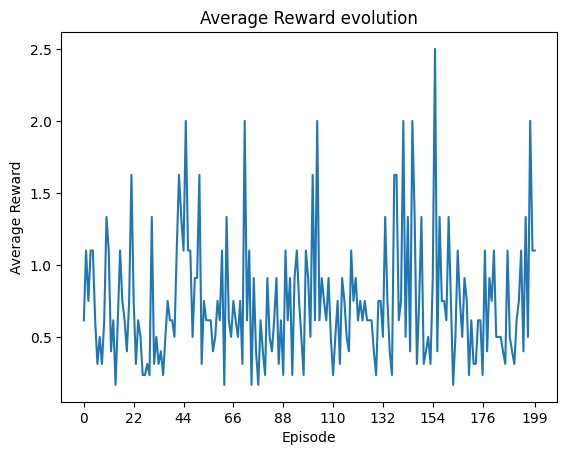

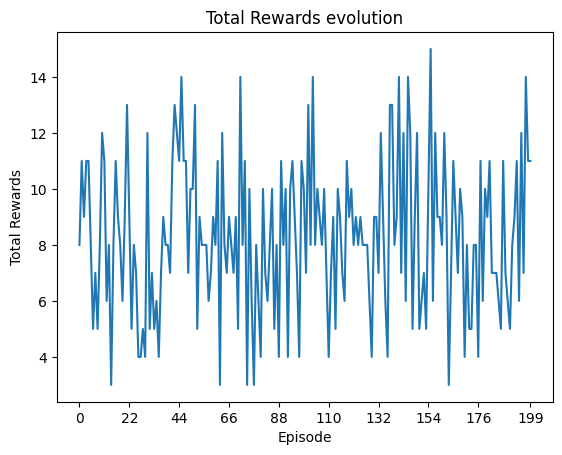

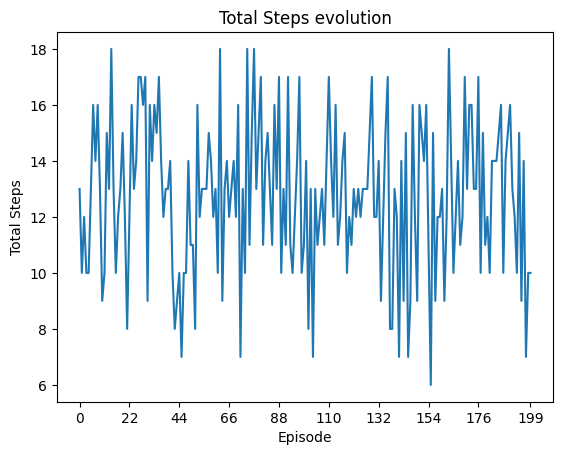

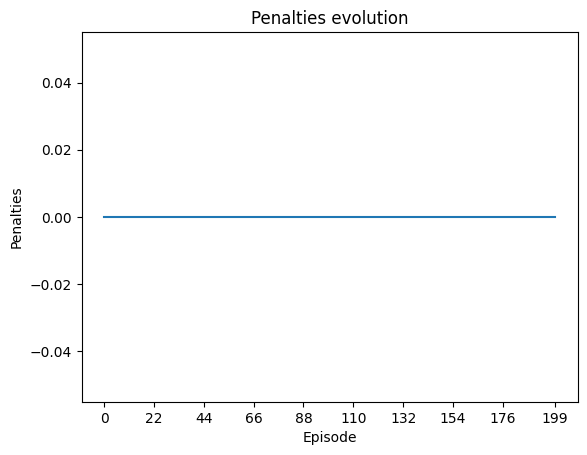

Average reward: 8.27


In [8]:
## q_table 1
average_reward = evaluate_agent(env
                                , q_table1
                                , episodes=200
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Evaluating agent...
Episode [0] [reward]: 4 - [reward/step]: 0.23529411764705882 - [penalties]: 0 - [total_steps]: 17
Episode [1] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [2] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [3] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [4] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [5] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [6] [reward]: 14 - [reward/step]: 2.0 - [penalties]: 0 - [total_steps]: 7
Episode [7] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [8] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [9] [reward]: 10 - [reward/step]: 0.9090909090909091 - [penalties]: 0 - [total_steps]: 11
Episode [10] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [11] [reward]: 9

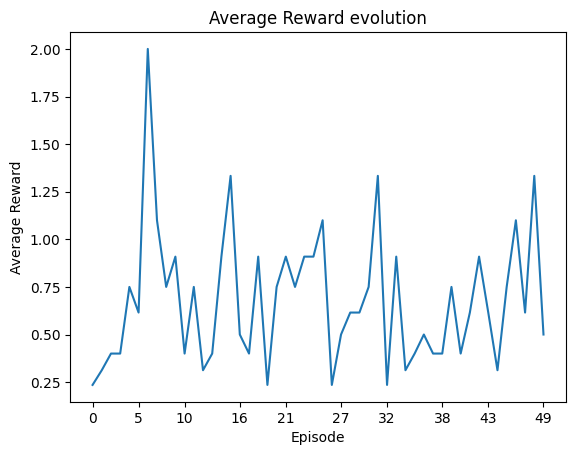

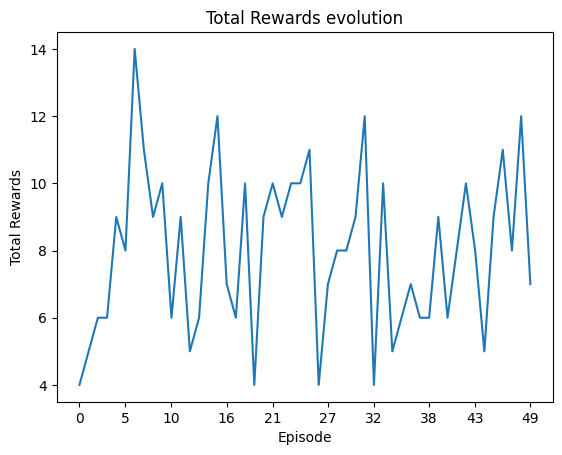

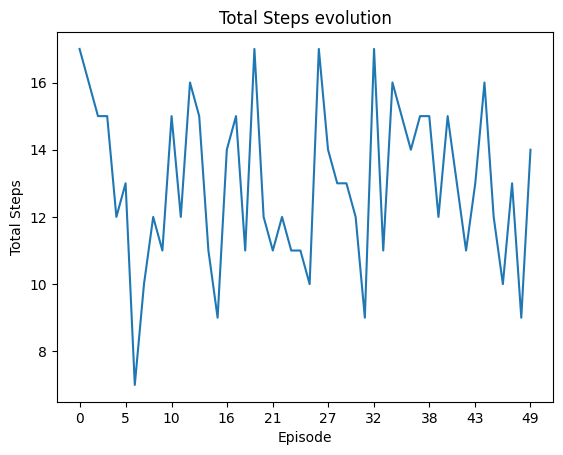

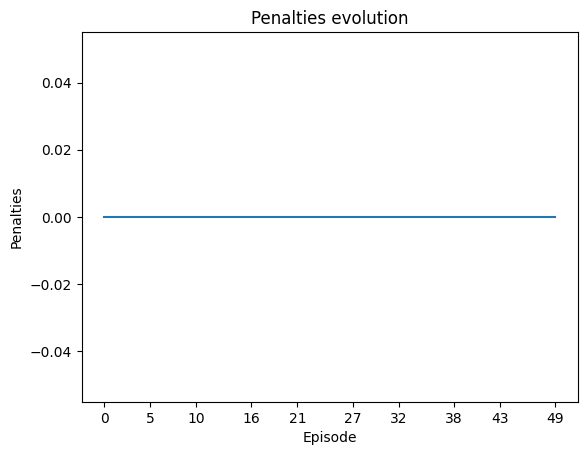

Average reward: 8.02


In [10]:
## q_table 2
average_reward = evaluate_agent(env
                                , q_table2
                                , episodes=50
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Combining training 1 & 2.

In [11]:
# Main execution
env = gym.make("Taxi-v3")
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=5000)
q_table2, rewards2 = train_q_learning(env, q_table1, episodes=5000)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


Episode: 500, Average reward (last 500 episodes): -1.728179106182723, current epsilon: 0.1
Episode: 1000, Average reward (last 500 episodes): -1.4062080294028654, current epsilon: 0.1
Episode: 1500, Average reward (last 500 episodes): -1.285841485380075, current epsilon: 0.1
Episode: 2000, Average reward (last 500 episodes): -1.1873285197207744, current epsilon: 0.1
Episode: 2500, Average reward (last 500 episodes): -1.1017009689199904, current epsilon: 0.1
Episode: 3000, Average reward (last 500 episodes): -1.0243449154180713, current epsilon: 0.1
Episode: 3500, Average reward (last 500 episodes): -0.9569301879727081, current epsilon: 0.1
Episode: 4000, Average reward (last 500 episodes): -0.8963014684059998, current epsilon: 0.1
Episode: 4500, Average reward (last 500 episodes): -0.8417232176052619, current epsilon: 0.1
Episode: 5000, Average reward (last 500 episodes): -0.7927272011429768, current epsilon: 0.1
Training finished.

Episode: 500, Average reward (last 500 episodes): -2.

Evaluating agent...
Episode [0] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [1] [reward]: 3 - [reward/step]: 0.16666666666666666 - [penalties]: 0 - [total_steps]: 18
Episode [2] [reward]: 12 - [reward/step]: 1.3333333333333333 - [penalties]: 0 - [total_steps]: 9
Episode [3] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [4] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [5] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [6] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [7] [reward]: 3 - [reward/step]: 0.16666666666666666 - [penalties]: 0 - [total_steps]: 18
Episode [8] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [9] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [10] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 

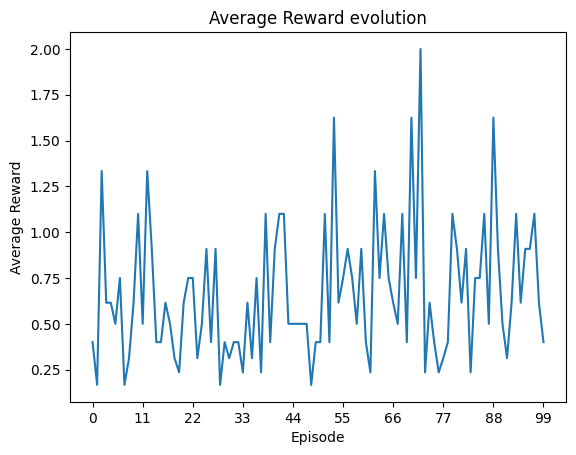

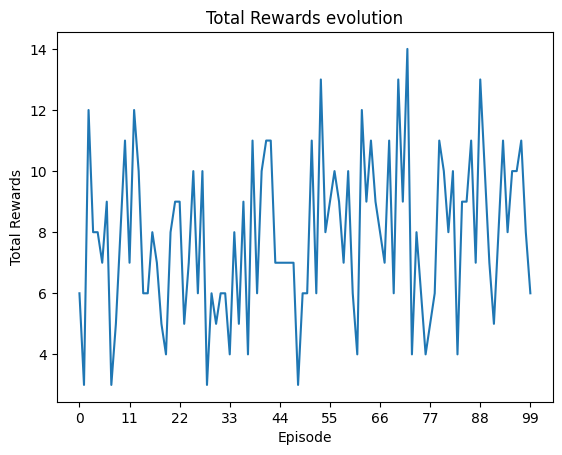

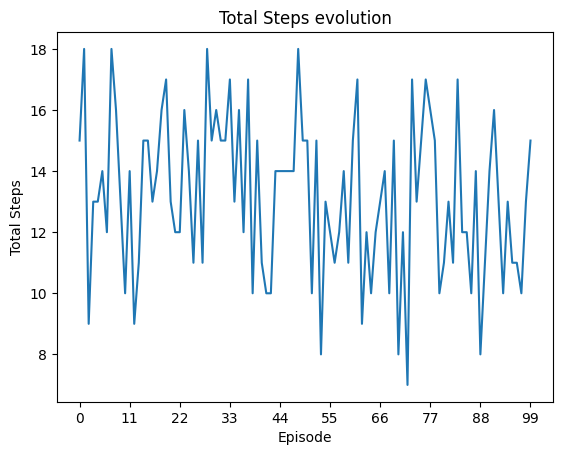

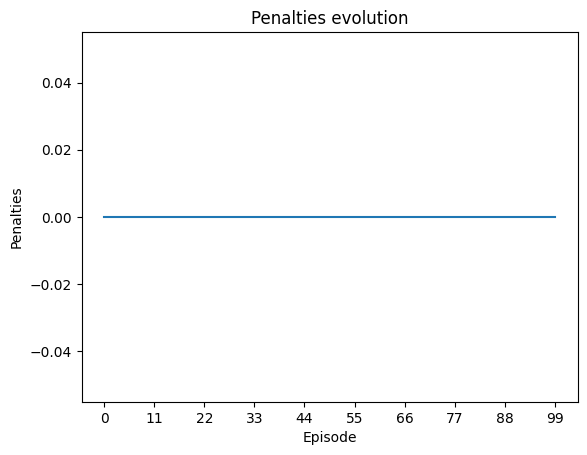

Average reward: 7.85


In [12]:
## q_table 1_2
average_reward = evaluate_agent(env
                                , q_table2
                                , episodes=100
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")